# Program - Plot domain-avg profiles in AM4

Content
- Read AM4 and SCM data
- Select time and region in AM4, and compute domain-averaged profiles
- Plot profiles using matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Read AM4 and SCM data

In [2]:
#--- open AM4 data
datapath = "../data/"
#filename = "data-am4_20010725_8xdaily-temp.nc"
filename = "cm4p12_xanadu_am4p0_edmf_mynn.tt1-c96L33_am4p0_cm4amip_nudge2000_Jul2001.1x0m30d_432x2a.atmos_8xdaily_inst.lat_lon.nc.20010710.nc"

files_input = datapath+"/"+filename

#--- use xarray to open the files
data = xr.open_dataset(files_input)
data

<xarray.Dataset>
Dimensions:   (phalf: 34, lat: 180, bnds: 2, levhalf: 34, lon: 288, time: 8,
               pfull: 33)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * levhalf   (levhalf) float64 1.0 0.9959 0.9897 ... 0.008186 0.004 0.001
  * lon       (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * pfull     (pfull) float64 2.164 5.845 10.75 17.11 ... 985.4 992.8 997.9
  * phalf     (phalf) float64 1.0 4.0 8.186 13.79 ... 981.1 989.7 995.9 1e+03
  * time      (time) object 2001-07-10 03:00:00 ... 2001-07-11 00:00:00
Dimensions without coordinates: bnds
Data variables: (12/14)
    bk        (phalf) float32 ...
    lat_bnds  (lat, bnds) float64 ...
    lon_bnds  (lon, bnds) float64 ...
    omega     (time, pfull, lat, lon) float32 ...
    pk        (phalf) float32 ...
    ps        (time, lat, lon) float32 ...
    ...        ...
    tdt_dyn   (time, pfull, lat, lon) float32 ...
    temp      (time, pfull, lat, lon) float32 ...
    ucomp     (time, pfull, lat, lon) float32 ...
    vcomp     (time, pfull, lat, lon) float32 ...
    zg        (time, levhalf, lat, lon) float32 ...
    zsurf     (lat, lon) float32 ...
Attributes:
    filename:              20010701.atmos_8xdaily_inst.tile1.nc
    title:                 tt1-c96L33_am4p0_cm4amip_nudge2000_Jul2001
    associated_files:      area: 20010701.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Sun Jul 17 14:26:29 2022
    hostname:              an011
    history:               Sun Jul 17 14:45:10 2022: ncks -F -d time,73,80 ./...
    NCO:                   "4.5.4"

In [3]:
#--- read SCM data

datapath = "../data/"

filename_scm_1xdiv = "SCM_am4_xanadu_edmf_mynn.v01_RF01-00cc-am4p0_aerT_clr_am4RAD_sw.1x0m5d_1x1a.atmos_edmf_mynn.nc"
filename_scm_2xdiv = "SCM_am4_xanadu_edmf_mynn.v01_RF01-00cc-am4p0_aerT_clr_am4RAD_sw_2Xdifv.1x0m5d_1x1a.atmos_edmf_mynn.nc"

files_scm_1xdiv = datapath+"/"+filename_scm_1xdiv
files_scm_2xdiv = datapath+"/"+filename_scm_2xdiv

#--- use xarray to open the files
scm_1xdiv = xr.open_dataset(files_scm_1xdiv)
scm_2xdiv = xr.open_dataset(files_scm_2xdiv)

## read data & print out variables for computing tendencies from vertical advection using SCM machinery

In [4]:
#--- set up
region = "DYCOMS"
#region = "Californian_Sc"
model = "AM4_L33_native"
time_step = "2001-07-10 09:00:00"

#--- get lat/lon of the region
lon_slice, lat_slice = yhc.get_region_latlon(region)

#--- read data
pt = data.temp.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
qq = data.sphum.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
omega = data.omega.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
tdt_dyn = data.tdt_dyn.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
qdt_dyn = data.qdt_dyn.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
zg = data.zg.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))

#--- read pressure levels
ps_region = data.ps.sel(lat=lat_slice, lon=lon_slice)
pfull_region = yhc.mlevs_to_plevs(ps_region, model = model, plevs = "pfull").stack(loc=("lat","lon"))
phalf_region = yhc.mlevs_to_plevs(ps_region, model = model, plevs = "phalf").stack(loc=("lat","lon"))

phalf = phalf_region.sel(time=time_step)

nn = 0
do_print = False

if (do_print):
    for nn in range(0,6):
        yhc.printv(phalf[0,:,nn],"phalf, n-th location = "+str(nn))
        yhc.printv(omega[0,:,nn],"omega, n-th location = "+str(nn))
        yhc.printv(pt[0,:,nn],"temp, n-th location = "+str(nn))
        yhc.printv(qq[0,:,nn],"qq, n-th location = "+str(nn))


pfull
phalf


## Output from SCM machinery

In [5]:
#*********************
#
# SCM experiment: xx2-RF01_A-vert_adv_offline_1x0m2d_1x1a.o269063129
#
#*********************

#--- create DataArray
tdt_vadv = tdt_dyn.copy()
qdt_vadv = qdt_dyn.copy()

tdt_vadv.attrs['long_name']='tdt_vadv'
qdt_vadv.attrs['long_name']='qdt_vadv'

#--- tdt & qdt vertical advection for each grid point
nn=0
tdt_vadv[0,:,nn] = [    0.0000E+00  ,  0.2925E-05  ,  0.1327E-05  ,  0.2221E-05  ,  0.4382E-05  ,  0.7099E-05  ,  0.5611E-05  ,  0.8380E-05  ,  0.8371E-05  ,  0.7937E-06  , -0.1365E-03  , -0.4276E-04  ,  0.1430E-04  ,  0.4421E-04  ,  0.1259E-04  , -0.4695E-04  , -0.5995E-04  , -0.6097E-04  , -0.6434E-04  , -0.5123E-04  , -0.5636E-04  , -0.5251E-04  , -0.6241E-04  , -0.2182E-04  , -0.3517E-06  ,  0.2041E-03  ,  0.3556E-05  , -0.4988E-04  , -0.2031E-04  , -0.1213E-04  , -0.5887E-05  , -0.1189E-05  ,  0.0000E+00]
qdt_vadv[0,:,nn] = [    0.0000E+00  , -0.9857E-14  , -0.3270E-14  , -0.6177E-16  ,  0.3195E-13  ,  0.1146E-12  ,  0.1654E-12  ,  0.2818E-14  , -0.1676E-11  , -0.1567E-13  ,  0.8651E-12  , -0.2295E-10  ,  0.4831E-10  ,  0.6171E-09  ,  0.3851E-09  , -0.2287E-08  , -0.4741E-08  , -0.1756E-08  , -0.3843E-09  , -0.2661E-07  , -0.1456E-07  , -0.9584E-09  ,  0.3462E-08  , -0.1474E-08  ,  0.5014E-07  , -0.1008E-06  , -0.4257E-07  , -0.3959E-08  , -0.1060E-08  , -0.6495E-09  , -0.3562E-09  , -0.1149E-09  ,  0.0000E+00]

nn=1
tdt_vadv[0,:,nn] = [-0.3832E-05  , -0.2676E-05  , -0.3925E-07  ,  0.1335E-05  ,  0.2765E-05  ,  0.5824E-05  ,  0.5728E-05  ,  0.5923E-05  ,  0.1183E-04  ,  0.1638E-05  , -0.1319E-03  , -0.5366E-04  , -0.4588E-05  ,  0.1298E-04  ,  0.1173E-04  , -0.2557E-04  , -0.6066E-04  , -0.6495E-04  , -0.5386E-04  , -0.5113E-04  , -0.6581E-04  , -0.7441E-04  , -0.5378E-04  , -0.7255E-04  , -0.2458E-04  ,  0.2504E-03  ,  0.3090E-04  , -0.4481E-04  , -0.2191E-04  , -0.1240E-04  , -0.5437E-05  ,  0.1242E-06  ,  0.0000E+00]
qdt_vadv[0,:,nn] = [0.6373E-14  ,  0.1519E-13  ,  0.4614E-28  ,  0.2642E-14  ,  0.1842E-13  ,  0.1144E-12  ,  0.1585E-12  ,  0.3656E-14  , -0.1071E-11  ,  0.2129E-11  , -0.5375E-11  , -0.8643E-11  , -0.1808E-10  ,  0.2376E-09  ,  0.4019E-09  , -0.1222E-08  , -0.4217E-08  , -0.2294E-08  , -0.1630E-08  , -0.2953E-07  , -0.2240E-07  , -0.3373E-08  ,  0.6034E-08  ,  0.7281E-09  ,  0.4589E-07  ,  0.8842E-08  , -0.1512E-06  , -0.1030E-07  , -0.2178E-08  , -0.8277E-09  , -0.4132E-09  ,  0.1648E-09  ,  0.0000E+00]

nn=2
tdt_vadv[0,:,nn] = [-0.1442E-04  , -0.1299E-04  , -0.4940E-05  , -0.3068E-05  , -0.2268E-05  ,  0.5135E-06  ,  0.1631E-05  ,  0.6489E-07  ,  0.8604E-05  ,  0.1546E-05  , -0.1034E-03  , -0.5911E-04  , -0.2740E-04  , -0.1213E-04  ,  0.2783E-04  ,  0.1497E-04  , -0.4764E-04  , -0.7271E-04  , -0.5589E-04  , -0.5124E-04  , -0.6035E-04  , -0.7429E-04  , -0.4599E-04  , -0.4738E-04  , -0.3763E-04  ,  0.1521E-03  ,  0.7059E-04  ,  0.3912E-06  , -0.2727E-04  , -0.5194E-05  ,  0.2613E-05  ,  0.1212E-04  ,  0.0000E+00]
qdt_vadv[0,:,nn] = [0.2292E-13  ,  0.8707E-13  , -0.6508E-15  , -0.7233E-14  , -0.1463E-13  ,  0.2876E-13  ,  0.5072E-13  ,  0.3509E-13  ,  0.0000E+00  ,  0.9344E-12  , -0.3098E-11  , -0.2935E-11  , -0.8575E-10  , -0.5794E-11  ,  0.6348E-09  ,  0.3141E-09  , -0.3640E-08  , -0.6172E-08  , -0.1435E-07  , -0.2363E-07  , -0.1055E-07  , -0.3409E-08  , -0.5135E-09  ,  0.1307E-07  ,  0.8864E-08  ,  0.4421E-07  , -0.1241E-06  , -0.2361E-07  , -0.2656E-08  , -0.3981E-09  ,  0.1916E-09  ,  0.2775E-08  ,  0.0000E+00]

nn=3
tdt_vadv[0,:,nn] = [-0.1484E-05  , -0.2060E-06  ,  0.1090E-05  ,  0.1372E-05  ,  0.3383E-05  ,  0.7979E-05  ,  0.8722E-05  ,  0.7436E-05  ,  0.2590E-05  ,  0.9557E-07  , -0.1218E-03  , -0.3206E-04  ,  0.6150E-05  ,  0.2609E-04  , -0.6147E-07  , -0.3273E-04  , -0.2388E-04  , -0.2407E-04  , -0.3859E-04  , -0.3937E-04  , -0.4274E-04  , -0.3856E-04  , -0.5412E-04  , -0.1771E-04  ,  0.1303E-03  ,  0.8514E-04  ,  0.6068E-06  , -0.4140E-04  , -0.1571E-04  , -0.9013E-05  , -0.4202E-05  , -0.6713E-06  ,  0.0000E+00]
qdt_vadv[0,:,nn] = [0.1948E-14  , -0.3053E-16  , -0.7772E-14  , -0.1673E-14  ,  0.1888E-13  ,  0.1667E-12  ,  0.2347E-12  ,  0.3955E-14  , -0.9213E-12  ,  0.3462E-12  ,  0.3053E-12  , -0.3092E-10  ,  0.2208E-10  ,  0.3861E-09  , -0.4668E-10  , -0.1133E-08  , -0.1742E-08  , -0.8917E-09  , -0.2818E-10  , -0.2102E-07  , -0.5129E-08  ,  0.1409E-07  ,  0.5266E-08  ,  0.4225E-08  ,  0.1558E-07  , -0.1249E-06  , -0.3146E-07  , -0.3175E-08  , -0.8264E-09  , -0.4973E-09  , -0.2655E-09  , -0.4450E-10  ,  0.0000E+00]

nn=4
tdt_vadv[0,:,nn] = [-0.1118E-04  , -0.9876E-05  , -0.1822E-05  ,  0.3611E-06  ,  0.9655E-06  ,  0.4247E-05  ,  0.7546E-05  ,  0.4832E-05  ,  0.4556E-05  ,  0.7102E-06  , -0.1265E-03  , -0.4422E-04  , -0.1111E-05  ,  0.1778E-04  ,  0.1157E-04  , -0.1200E-04  , -0.1461E-04  , -0.1809E-04  , -0.3275E-04  , -0.4423E-04  , -0.5395E-04  , -0.5126E-04  , -0.4492E-04  , -0.4195E-04  , -0.8328E-05  ,  0.2557E-03  ,  0.1924E-04  , -0.4868E-04  , -0.2012E-04  , -0.1072E-04  , -0.3926E-05  ,  0.1839E-05  ,  0.0000E+00]
qdt_vadv[0,:,nn] = [0.1378E-13  ,  0.3305E-13  ,  0.1972E-13  ,  0.0000E+00  ,  0.5092E-14  ,  0.1049E-12  ,  0.1738E-12  ,  0.4200E-14  , -0.2394E-12  ,  0.2056E-11  , -0.5141E-11  , -0.1518E-10  , -0.1291E-10  ,  0.3395E-09  ,  0.4453E-09  , -0.6043E-09  , -0.7649E-09  , -0.8893E-10  ,  0.2111E-09  , -0.2433E-07  , -0.1907E-07  , -0.2871E-08  ,  0.2081E-07  ,  0.8185E-08  ,  0.2444E-07  , -0.5201E-07  , -0.1138E-06  , -0.8918E-08  , -0.2018E-08  , -0.6991E-09  , -0.3008E-09  ,  0.5262E-09  ,  0.0000E+00]

nn=5
tdt_vadv[0,:,nn] = [-0.1575E-04  , -0.1642E-04  , -0.5683E-05  , -0.2586E-05  , -0.2853E-05  , -0.5393E-06  ,  0.3757E-05  , -0.1041E-05  ,  0.3232E-05  ,  0.9086E-06  , -0.1100E-03  , -0.4745E-04  , -0.8219E-05  ,  0.2164E-04  ,  0.5668E-04  ,  0.3440E-04  , -0.1640E-04  , -0.4205E-04  , -0.4229E-04  , -0.4201E-04  , -0.4339E-04  , -0.4500E-04  , -0.2924E-04  , -0.3835E-04  , -0.2362E-04  ,  0.1905E-03  ,  0.4604E-04  ,  0.7387E-07  , -0.3352E-04  , -0.7200E-05  ,  0.1953E-05  ,  0.1272E-04  ,  0.0000E+00]
qdt_vadv[0,:,nn] = [0.1823E-13  ,  0.6098E-13  ,  0.4766E-13  , -0.6187E-15  , -0.1237E-13  ,  0.1523E-13  ,  0.6235E-13  ,  0.1041E-11  , -0.2864E-26  ,  0.1073E-11  , -0.2312E-11  , -0.6186E-11  , -0.4684E-10  ,  0.5537E-09  ,  0.1568E-08  ,  0.7882E-09  , -0.7770E-09  , -0.1016E-08  , -0.1373E-08  , -0.2034E-07  , -0.1811E-07  , -0.5231E-08  ,  0.9691E-08  ,  0.1083E-07  ,  0.1491E-07  ,  0.1039E-07  , -0.1349E-06  , -0.2584E-07  , -0.3395E-08  , -0.6878E-09  ,  0.1391E-09  ,  0.2829E-08  ,  0.0000E+00]

#yhc.printv(tdt_dyn[0,:,5],'tdt_dyn')
#yhc.printv(tdt_vadv[0,:,5],'tdt_vadv')


## Making variables for plotting

In [6]:
#--- compute horizontal advection tendencies
tdt_hadv = tdt_dyn - tdt_vadv
tdt_hadv.attrs['long_name']="tdt_hadv"

qdt_hadv = qdt_dyn - qdt_vadv
qdt_hadv.attrs['long_name']="qdt_hadv"

#--- get domain-avg geopotential height
zg_ijavg = zg[0,:].mean("loc")
zfull = zg_ijavg.rolling(levhalf=2, center=True).mean().dropna("levhalf")
zfull = zfull[::-1]

#--- get domain-avg temp, specific humidity, and omega
pt_ijavg = pt[0,:,:].mean("loc")
qq_ijavg = qq[0,:,:].mean("loc")
omega_ijavg = omega[0,:,:].mean("loc")

#--- get domain-avg profiles for plotting
tdt_dyn_ijavg = tdt_dyn[0,:,:].mean("loc")
tdt_hadv_ijavg = tdt_hadv[0,:,:].mean("loc")
tdt_vadv_ijavg = tdt_vadv[0,:,:].mean("loc")

qdt_dyn_ijavg = qdt_dyn[0,:,:].mean("loc")
qdt_hadv_ijavg = qdt_hadv[0,:,:].mean("loc")
qdt_vadv_ijavg = qdt_vadv[0,:,:].mean("loc")

#yhc.printv(tdt_dyn_ijavg, "tdt_dyn_ijavg")
#yhc.printv(tdt_vadv_ijavg, "tdt_vadv_ijavg")
#yhc.printv(tdt_hadv_ijavg, "tdt_hadv_ijavg")


## plott - tdt

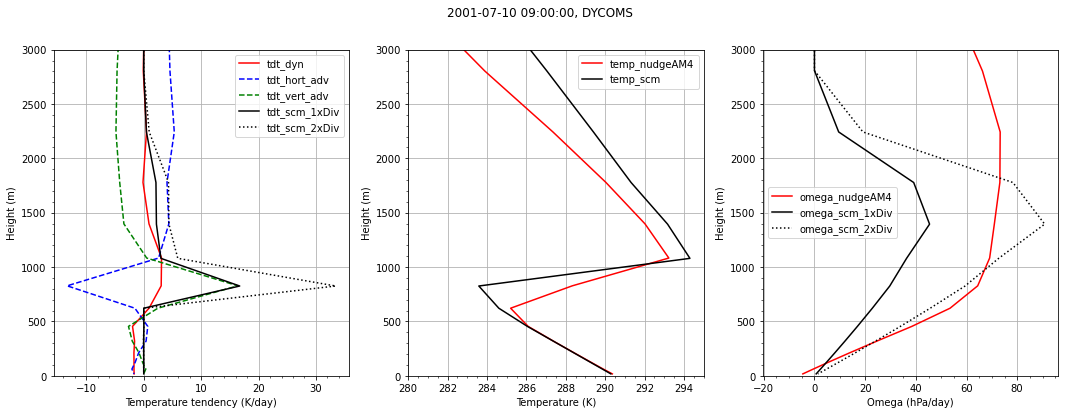

In [7]:
zmin = 0.
zmax = 3000.

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6))

fig.suptitle(time_step+", "+region)

#--- subplot 1: temp tendencies
ax1.plot(tdt_dyn_ijavg*86400., zfull, 'r',
         tdt_hadv_ijavg*86400., zfull,'b--',
         tdt_vadv_ijavg*86400., zfull,'g--',
         scm_1xdiv.tdt_vadv[0,:,0,0]*86400., scm_1xdiv.zfull[0,:,0,0], 'k',
         scm_2xdiv.tdt_vadv[0,:,0,0]*86400., scm_2xdiv.zfull[0,:,0,0], 'k:'
        )
ax1.grid(True)
ax1.set_ylim([zmin, zmax])
ax1.legend(["tdt_dyn","tdt_hort_adv","tdt_vert_adv","tdt_scm_1xDiv","tdt_scm_2xDiv"])
ax1.set_xlabel("Temperature tendency (K/day)")
ax1.set_ylabel("Height (m)")

ax1.minorticks_on()

#--- subplot 2: temperature
ax2.plot(pt_ijavg, zfull, 'r',
         scm_1xdiv.temp[0,:,0,0], scm_1xdiv.zfull[0,:,0,0], 'k',
        )
ax2.grid(True)

ax2.set_ylim([zmin, zmax])
ax2.set_xlim([280., 295.])

ax2.legend(["temp_nudgeAM4","temp_scm"])
ax2.set_xlabel("Temperature (K)")
ax2.set_ylabel("Height (m)")

ax2.minorticks_on()

#--- subplot 3: omega
ax3.plot(omega_ijavg*864., zfull, 'r', 
         scm_1xdiv.omega[0,:,0,0]*864., scm_1xdiv.zfull[0,:,0,0], 'k',
         scm_2xdiv.omega[0,:,0,0]*864., scm_2xdiv.zfull[0,:,0,0], 'k:',
        )
ax3.grid(True)

ax3.set_ylim([zmin, zmax])
#ax3.set_xlim([280., 295.])

ax3.legend(["omega_nudgeAM4","omega_scm_1xDiv","omega_scm_2xDiv"])
ax3.set_xlabel("Omega (hPa/day)")
ax3.set_ylabel("Height (m)")

ax3.minorticks_on()



## Plot - qdt

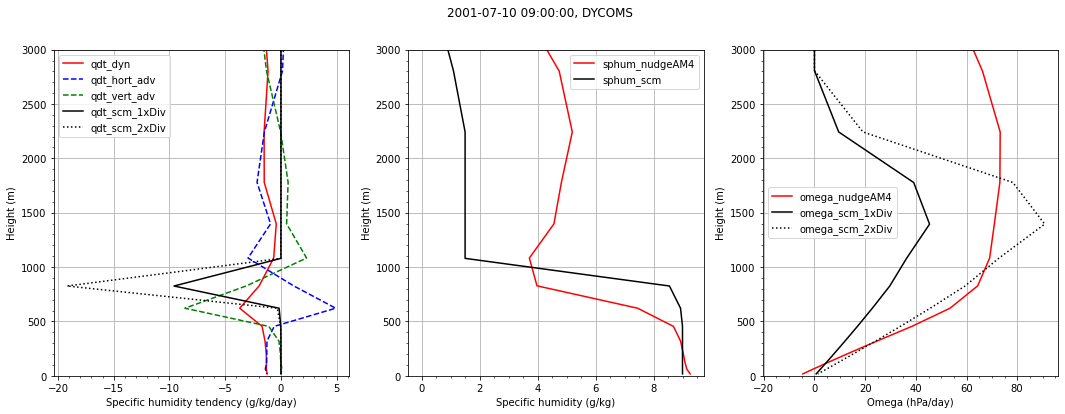

In [8]:
zmin = 0.
zmax = 3000.

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6))

fig.suptitle(time_step+", "+region)

#--- subplot 1: temp tendencies
ax1.plot(qdt_dyn_ijavg*86400.*1000., zfull, 'r',
         qdt_hadv_ijavg*86400.*1000., zfull,'b--',
         qdt_vadv_ijavg*86400.*1000., zfull,'g--',
         scm_1xdiv.qvdt_vadv[0,:,0,0]*86400.*1000., scm_1xdiv.zfull[0,:,0,0], 'k',
         scm_2xdiv.qvdt_vadv[0,:,0,0]*86400.*1000., scm_2xdiv.zfull[0,:,0,0], 'k:'
        )
ax1.grid(True)
ax1.set_ylim([zmin, zmax])
ax1.legend(["qdt_dyn","qdt_hort_adv","qdt_vert_adv","qdt_scm_1xDiv","qdt_scm_2xDiv"])
ax1.set_xlabel("Specific humidity tendency (g/kg/day)")
ax1.set_ylabel("Height (m)")
ax1.minorticks_on()

#--- subplot 2: temperature
ax2.plot(qq_ijavg*1000., zfull, 'r',
         scm_1xdiv.sphum[0,:,0,0]*1000., scm_1xdiv.zfull[0,:,0,0], 'k',
        )
ax2.grid(True)

ax2.set_ylim([zmin, zmax])
#ax2.set_xlim([280., 295.])

ax2.legend(["sphum_nudgeAM4","sphum_scm"])
ax2.set_xlabel("Specific humidity (g/kg)")
ax2.set_ylabel("Height (m)")
ax2.minorticks_on()

#--- subplot 3: omega
ax3.plot(omega_ijavg*864., zfull, 'r', 
         scm_1xdiv.omega[0,:,0,0]*864., scm_1xdiv.zfull[0,:,0,0], 'k',
         scm_2xdiv.omega[0,:,0,0]*864., scm_2xdiv.zfull[0,:,0,0], 'k:',
        )
ax3.grid(True)

ax3.set_ylim([zmin, zmax])
#ax3.set_xlim([280., 295.])

ax3.legend(["omega_nudgeAM4","omega_scm_1xDiv","omega_scm_2xDiv"])
ax3.set_xlabel("Omega (hPa/day)")
ax3.set_ylabel("Height (m)")
ax3.minorticks_on()

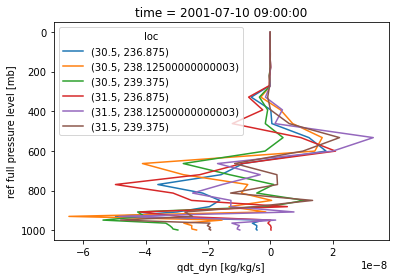

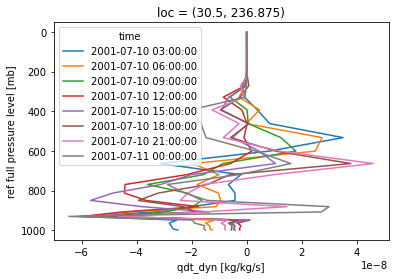

In [9]:
#--- quick plot
time_step = "2001-07-10 07:30:00"
var_region = data.qdt_dyn.sel(lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))

tt = 2
var = var_region[tt, :,:]
#print(var)

var.plot.line(y="pfull", yincrease=False)
plt.show()

nn=0
var_tp = var_region[:,:,nn]
var_tp.plot.line(y="pfull", yincrease=False)
plt.show()